# Setup

In [194]:
# Initializing libraries
library(readr)
library(dplyr)
library(lubridate)
library(ggplot2)
library(gridExtra)
library(purrr)
library(e1071)
library(caret)
options(warn=-1)

ERROR: Error in library(e1071): there is no package called ‘e1071’


In [95]:
#data reads
dataTrain = read_csv('~/Downloads/train.csv', col_names = TRUE)
dataTest = read_csv('~/Downloads/test.csv', col_names = TRUE)
dataTripRating = read_csv('~/Downloads/trip_rating.csv',col_names = TRUE)

Parsed with column specification:
cols(
  X1 = col_integer(),
  customer_id = col_integer(),
  driver_id = col_integer(),
  creation_date = col_datetime(format = ""),
  booking_source = col_integer(),
  car_type = col_integer(),
  estimated_distance = col_double(),
  distance_travelled = col_double(),
  distance_travelled_while_moving = col_double(),
  estimated_duration = col_integer(),
  duration_time = col_integer(),
  wait_time_initial = col_integer(),
  wait_time_in_journey = col_integer(),
  estimated_price = col_double(),
  price = col_double(),
  is_cancelled = col_integer(),
  rating = col_integer(),
  was_rated = col_integer()
)
Parsed with column specification:
cols(
  X1 = col_integer(),
  customer_id = col_integer(),
  driver_id = col_integer(),
  creation_date = col_datetime(format = ""),
  booking_source = col_integer(),
  car_type = col_integer(),
  estimated_distance = col_double(),
  distance_travelled = col_double(),
  distance_travelled_while_moving = col_double(),


Merging train & test data sets as dataMerged with ine additional column to indicate source. dataMerged will be used only for descriptive stats & quality inspection

In [4]:
dataTrain = dataTrain %>% mutate(dataType = 'Train')
dataTest = dataTest %>% mutate(dataType = 'Test', rating = NA, was_rated = NA) #adding NA's to missing columns
dataMerged = bind_rows(dataTrain,dataTest)

# Initial Observations & Data Quality
Deriving simple summary stats for both train and test data sets

In [7]:
paste('--TABLE 1 (Train & Test Data Stats)--')
dataMerged %>% split(.$dataType) %>% map(summary)

[1] "--TABLE 1 (Train & Test Data Stats)--"

$Test
       X1         customer_id         driver_id      
 Min.   :    0   Min.   :  577000   Min.   : 509300  
 1st Qu.: 4300   1st Qu.:21903388   1st Qu.:1295000  
 Median : 8600   Median :41045948   Median :1720468  
 Mean   : 8600   Mean   :37959402   Mean   :1578781  
 3rd Qu.:12900   3rd Qu.:53708472   3rd Qu.:1957772  
 Max.   :17200   Max.   :63884044   Max.   :2203644  
                                                     
 creation_date                 booking_source     car_type    
 Min.   :2017-08-26 00:32:16   Min.   :1.000   Min.   :1.000  
 1st Qu.:2017-09-02 21:15:17   1st Qu.:1.000   1st Qu.:1.000  
 Median :2017-09-11 10:30:23   Median :1.000   Median :1.000  
 Mean   :2017-09-11 03:19:54   Mean   :1.487   Mean   :1.095  
 3rd Qu.:2017-09-19 08:33:07   3rd Qu.:2.000   3rd Qu.:1.000  
 Max.   :2017-09-26 23:42:05   Max.   :4.000   Max.   :5.000  
                                                              
 estimated_distance distance_travelled distance_travelled_

Next we derive {price, distance, time plots} for cases when the trip was on or cancelled for both Train & Test data set

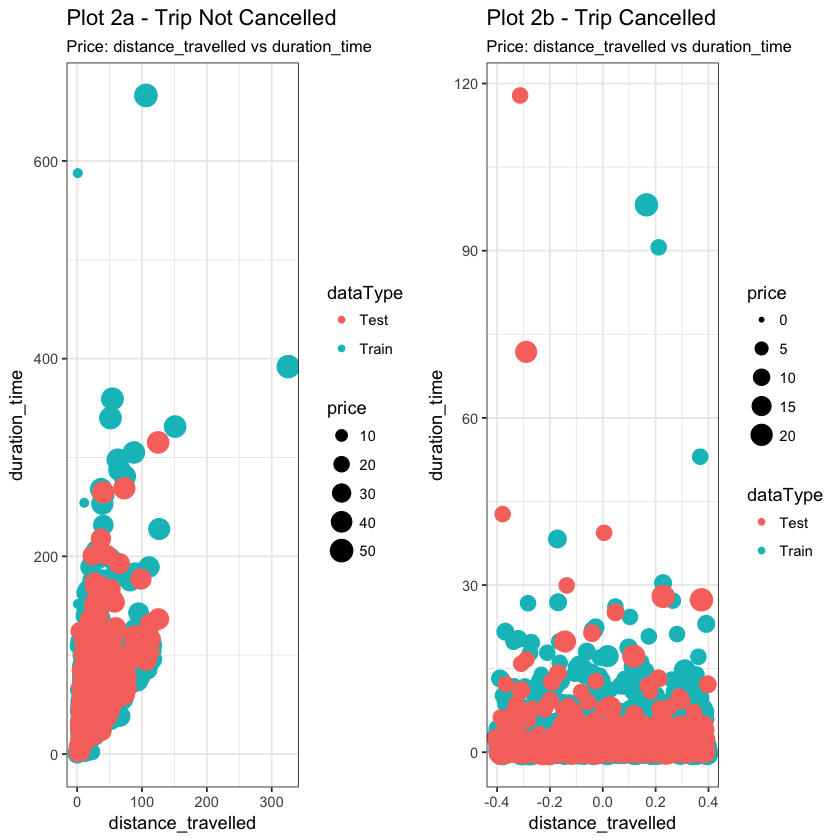

In [33]:
# Plots for Price,Distance & Time for trip cancelled not cancelled in train & test Data - PLOT 1
dataMergedPlotNotCancel = dataMerged %>% filter(is_cancelled == 0)

gNotCancelPlot = ggplot(dataMergedPlotNotCancel, aes(x = distance_travelled, y = duration_time)) + 
    labs(subtitle="Price: distance_travelled vs duration_time",title = 'Plot 2a - Trip Not Cancelled') + 
    geom_jitter(aes(col=dataType,size = price)) 

dataMergedPlotCancel = dataMerged %>% filter(is_cancelled == 1)
gCancelPlot = ggplot(dataMergedPlotCancel, aes(x = distance_travelled, y = duration_time,size = price))+
    labs(subtitle="Price: distance_travelled vs duration_time",title = 'Plot 2b - Trip Cancelled') + 
    geom_jitter(aes(col=dataType,size = price)) 

theme_set(theme_bw()) 
grid.arrange(gNotCancelPlot,gCancelPlot,ncol = 2)

__INFERENCES__
-  Train data set has an extra car type 6 [Table 1]
-  In case of real trip with cancelled status = 0, clutter of points observed origin in plot 2a, real trips with 0 time & distance
-  [Plot 2] shows certain anomalies in the test data & overall distribution non-conformal with train set, this will affect prediction at these points in the train set
-  [Plot 2b] for this case reveals negative distances which need to be investigated further. Also negative time units seen in [Table 1] for wait_time_in_journey. Deep dive into the data revealed this precence in both test & train sets. Need domain inputs to investigate further.
-  No class imbalance problem percieved for predicting rating probablity

Investigating further on negative distances & time units. We look further into the price distribution of these cases in both test & train data

In [38]:
paste('--TABLE 2 (Obs where Trip cancelled status was 0 & either total distance or time <=0)--')
dataMerged %>% filter(is_cancelled ==0 & (duration_time <= 0 | distance_travelled <=0)) %>% #filtering 0 cases & real trips
    group_by(dataType) %>% summarise(count = n(),mean_price = mean(price),sd_price = sd(price)) # summarising

[1] "--TABLE 2 (Obs where Trip cancelled status was 0 & either total distance or time <=0)--"

dataType,count,mean_price,sd_price
Test,94,9.631833,1.705823
Train,220,9.923791,2.207674


__INFERENCES__
-  [Table 2] reveal 0 distances & times with price for real trips i.e. trips without cancellation. Occurs in both test & train sets ~0.5% across & need more inputs from domain to infer & clean.

Next we investigte rating v.s. cancellation status to check if trips cancelled have been rated in Train data

In [39]:
# rating vs cancellation dist
paste('--TABLE 3 (Dist of Rating levels v.s.Cancellation)--')
dataTrain %>% group_by(is_cancelled,rating) %>% summarise(count =n())

[1] "--TABLE 3 (Dist of Rating levels v.s.Cancellation)--"

is_cancelled,rating,count
0,0,14021
0,1,706
0,2,211
0,3,576
0,4,3086
0,5,30298
1,0,2185


__Inferences__
-  For the case of cancelled trips no rating is provided by the customer, as seen in [Table 3]. Can be used as a rule to predict was_rated in test data

We next investigate data from trip_rating data set & specifically look:

-  customer_id similarity across train, test & trip_rating data sets
-  Derive prob of providing a rating using trip_rating dta & contrast it with avg rating provided & num of trips to draw inferences

In [40]:
paste('-- Table 4 Customer ID stats from Train, Test & Trip Rating data sets')
paste('Num of distinct customers in Train set:', length(unique(dataTrain$customer_id)), sep = ' ')
paste('Num of distinct customers in Test set:', length(unique(dataTest$customer_id)), sep = ' ')
paste('Num of distinct customers in Trip Rating set:', length(unique(dataTripRating$customer_id)), sep = ' ')

trainCustId = unique(dataTrain$customer_id)
tripCustId = unique(dataTripRating$customer_id)
testCustId = unique(dataTest$customer_id)


paste('proportion of customers in Train set observed in Trip Rating set:', length(trainCustId[which((trainCustId %in% tripCustId))])/length(trainCustId), sep = ' ')
paste('proportion of customers in Test set observed in Trip Rating set:', length(testCustId[which((testCustId %in% tripCustId))])/length(testCustId), sep = ' ')
paste('proportion of customers in Test set observed in Train set:', length(testCustId[which((testCustId %in% trainCustId))])/length(testCustId), sep = ' ')

[1] "-- Table 4 Customer ID stats from Train, Test & Trip Rating data sets"

[1] "Num of distinct customers in Train set: 9000"

[1] "Num of distinct customers in Test set: 3000"

[1] "Num of distinct customers in Trip Rating set: 6269"

[1] "proportion of customers in Train set observed in Trip Rating set: 0.518555555555556"

[1] "proportion of customers in Test set observed in Trip Rating set: 0.534"

[1] "proportion of customers in Test set observed in Train set: 0"

For insights on prob of providing a rating we first add a was_rated var in the trip rating data set

In [138]:
dataTripRatingTransform = dataTripRating %>% mutate(was_rated = ifelse(rating == 0, 0,1))

Summarising info at customer_id level & adding new vars - trips, avgRating & rating_prob(prob of providing a rating) & also provide mean, median computations for rating_prob

In [139]:
dataTripRatingTransformRatingProb = dataTripRatingTransform %>% select(-X1,-driver_id) %>% 
    group_by(customer_id) %>% summarise(trips = n(),rating_prob = mean(was_rated)) %>% 
    ungroup()
dataTripRatingTransformAvgRating = dataTripRating %>% select(-X1,-driver_id) %>% filter(rating > 0) %>%
    group_by(customer_id) %>% summarise(avgRating = mean(rating)) %>% 
    ungroup()

dataTripRatingTransform = left_join(dataTripRatingTransformRatingProb,dataTripRatingTransformAvgRating, by = 'customer_id')
dataTripRatingTransform = dataTripRatingTransform %>% filter(!is.na(avgRating))
paste('-- Table 5a Customer ID related Avg rating & rating prob from Trip Rating set')
head(dataTripRatingTransform)

paste('Median Prob to rate:', median(dataTripRatingTransform$rating_prob))
paste('Mean Prob to rate:', mean(dataTripRatingTransform$rating_prob))

[1] "-- Table 5a Customer ID related Avg rating & rating prob from Trip Rating set"

customer_id,trips,rating_prob,avgRating
409200,10,0.9000000,4.888889
448156,9,0.8888889,4.875000
455204,1,1.0000000,5.000000
522464,17,0.8235294,4.928571
595616,8,0.6250000,5.000000
675648,57,0.9824561,5.000000


[1] "Median Prob to rate: 0.736842105263158"

[1] "Mean Prob to rate: 0.711703097898472"

Next we look at the histogram plots for rating_prob & contrast it with avgRating.
However before doing this step we further transform avgRating to a level x if avgRating < x.5

In [140]:
paste('-- Table 5b Customer ID related Avg rating(transformed) & rating prob from Trip Rating set')
dataTripRatingTransform = dataTripRatingTransform %>% 
    mutate(transAvgRating = ifelse(avgRating<1.5, 1, ifelse(avgRating<2.5,2,ifelse(avgRating<3.5,3,ifelse(avgRating<4.5,4,5)))))
head(dataTripRatingTransform)

[1] "-- Table 5b Customer ID related Avg rating(transformed) & rating prob from Trip Rating set"

customer_id,trips,rating_prob,avgRating,transAvgRating
409200,10,0.9000000,4.888889,5
448156,9,0.8888889,4.875000,5
455204,1,1.0000000,5.000000,5
522464,17,0.8235294,4.928571,5
595616,8,0.6250000,5.000000,5
675648,57,0.9824561,5.000000,5


In [141]:
dataTripRatingTransform %>% group_by(transAvgRating) %>% 
    summarise(mean_rating_prob = mean(rating_prob),median_rating_prob = median(rating_prob))

transAvgRating,mean_rating_prob,median_rating_prob
1,0.6470370,0.5000000
2,0.5812729,0.5000000
3,0.6824148,0.6666667
4,0.6743113,0.6666667
5,0.7195884,0.7500000


Plotting histograms & densities -

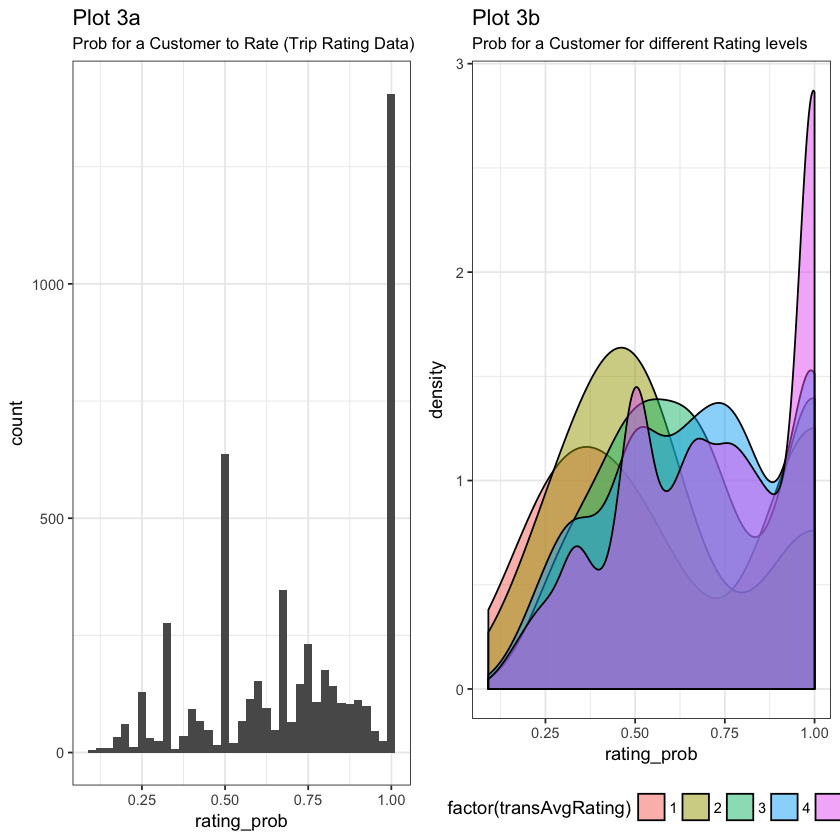

In [124]:
gDens = ggplot(dataTripRatingTransform, aes(rating_prob)) + 
    geom_density(aes(fill=factor(transAvgRating)),alpha = 0.5) + 
    labs(subtitle ='Prob for a Customer for different Rating levels',title = 'Plot 3b') + theme(legend.position="bottom")
gHist = ggplot(dataTripRatingTransform, aes(rating_prob)) + 
    geom_histogram(binwidth = .025) + 
    labs(subtitle = 'Prob for a Customer to Rate (Trip Rating Data)', title = 'Plot 3a')
#hist(dataTripRatingTransform$rating_prob,main = '-- Plot 3 Prob for a Customer to Rate (Trip Rating Data)--')
theme_set(theme_bw()) 
grid.arrange(gHist,gDens, ncol = 2)

Peaks or modes in [Plot 3b] are related to number of trips to make this more evident we next include the trip information in teh following scatter plot, which is much aking to [Plot 3b]

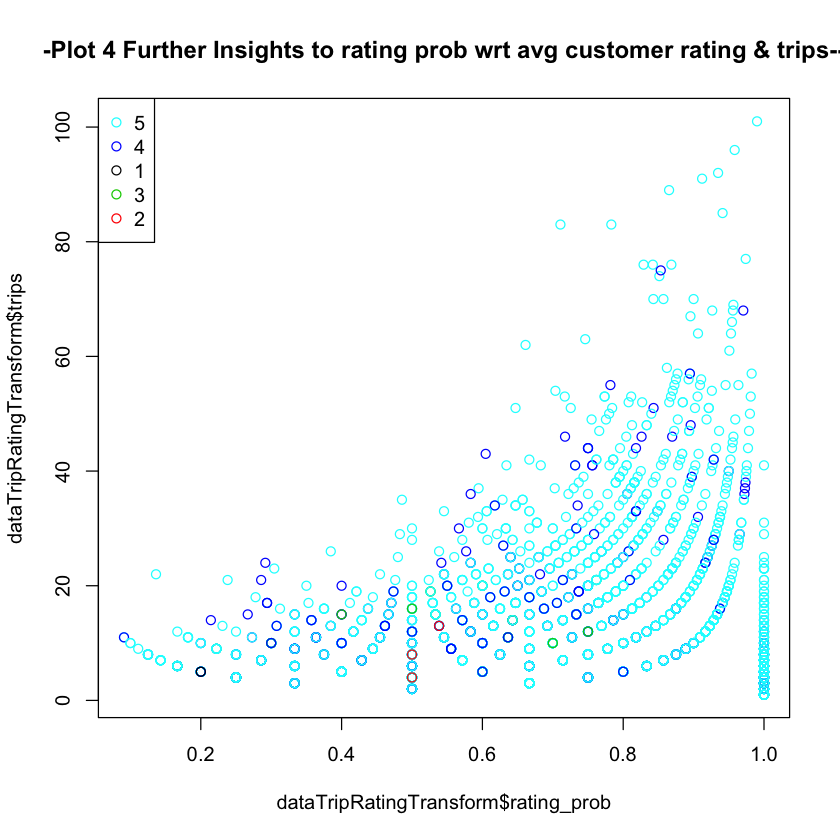

In [125]:
plot(dataTripRatingTransform$rating_prob,dataTripRatingTransform$trips,col = dataTripRatingTransform$transAvgRating,main = '-Plot 4 Further Insights to rating prob wrt avg customer rating & trips--')
legend(x="topleft", legend = unique(dataTripRatingTransform$transAvgRating), col=unique(dataTripRatingTransform$transAvgRating), pch=1)

__Inferences__
-  From [Plot 3a] we can infer rating_prob has more of a beta/uniform density
-  In [Plot 3b] a breakup of the density highlights a linear relationship between trip rating & rating_prob evident directly i.e. more satisfied the customer is with the trip(or the service in this case as the rating is reported as an average) the more likely he/she is to rate. 
- Overall customers satisfied with the service over more number of trips are likely to rate a trip

# Hyp 1 : Customers travelling greater distances are more likely to request for price estimation

Let $X$ represent distribution of distance for all customers who did not make a price request. Similarly let $Y$ be the distance distribution of customers who made a price request.

With these representations we want to verify the validity of the following hypothesis
\begin{equation}
H_0: X = Y \\
H_1:  X<Y 
\end{equation}

Where the alternative $H_1$ represents the problem statement. It would be tempting to assume these distance distribution to be normal & use a t-test on means. However checking for the normality of $X$ & $Y$ precedes the t-test.

In the following steps we first create a additional var priceReq which indicates if a price request was made & then check for normaility of the distributions after splitting the data based on priceReq.

We implement the following cleaning rules based on our inferences from earlier section:

For either cases when price is req or not we filter data for (is_cancelled ==1 & distance_travelled ==0) | (is_cancelled ==0 & distance_travelled >0)

This cleaning rule elminates spurious data observed in the earlier section when a trip was cancelled but distance_travelled was <=0, which will affect the results of the hypothesis testing.

Train data set is only used in this case.

In [67]:
hyp1Data = dataTrain %>% mutate(priceReq = ifelse(estimated_price > 0 ,1,0)) %>% 
    filter((is_cancelled ==1 & distance_travelled ==0)| (is_cancelled ==0 & distance_travelled >0))

Summary stats for both cases of price req is provided in the table below

In [68]:
hyp1Data %>% group_by(priceReq) %>% summarise(avgDist = mean(distance_travelled),sdDist = sd(distance_travelled))

priceReq,avgDist,sdDist
0,6.654017,6.229871
1,8.048338,9.232368


We also plot histogram plots for both cases in the following plot

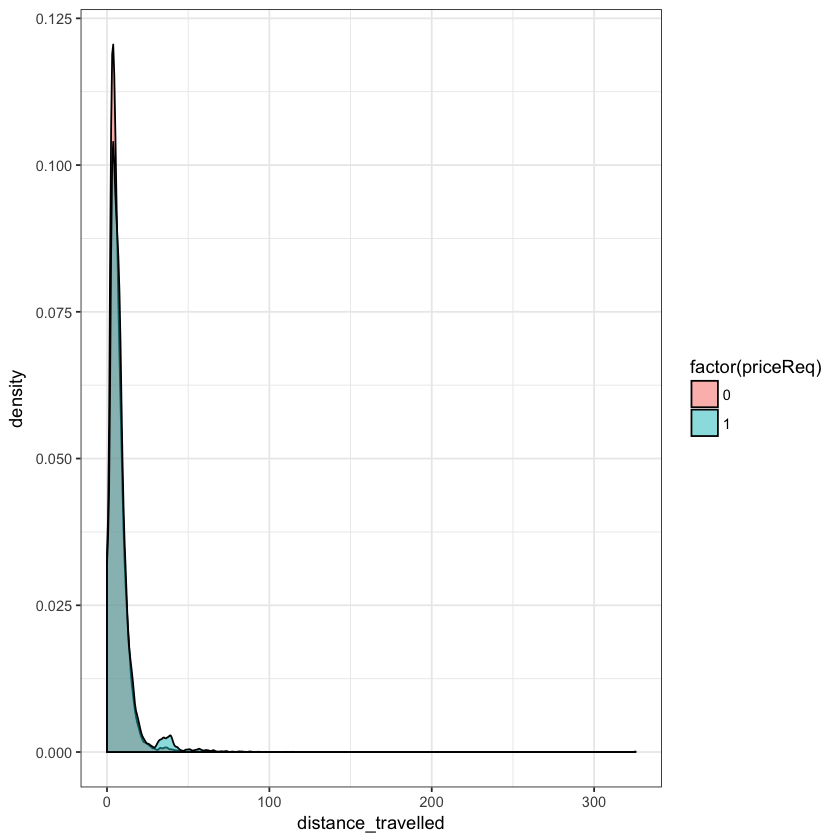

In [74]:
ggplot(hyp1Data, aes(distance_travelled)) + geom_density(aes(fill=factor(priceReq)),alpha = 0.5)

__Inferences__
-  For the case when a price request was made the distribution of distance looks multimodal/mixture. This mode also appears for the case when a price request wasn't made but the mode is significantly smaller
- From summary stats it seems that for the case when price req is made the distance means & variance too are marginally higher but this has to be confirmed via statistical test.
- Distance distribution in both cases look non-normal with thicker & longer righttail & in the next section we will confirm on this

A Shapiro-Wilks test can be used to confirm on the normality of distance distribution for both cases. However for larger sample sizes 5k+, this test generally fails as it could detect too many deviations from normaility.
To overcome this for each case we sample 5K odd points from each distribution & present an average p-val over iterations.

In [77]:
resultDf = data.frame()

for(priceTrainPrReq in c(0,1)){
iter = 0
maxIter = 5
pval = 0
sampleSize = 5000
dataTrainFilter = hyp1Data %>% filter(priceReq == priceTrainPrReq)
while(iter <= maxIter){
    pval = pval + shapiro.test(sample(dataTrainFilter$distance_travelled,sampleSize))$p.value
    iter = iter + 1
}#end which
    resultDf = bind_rows(resultDf, c('PriceReq' = priceTrainPrReq , 'Pval' = pval/(iter-1)))
    }#end for

resultDf

PriceReq,Pval
0,7.942999e-69
1,1.014205e-77


The null hypothesis for the above test states each distance distribution is normal. Given the estimated p-values we fail to accept the null hypothesis and hence use a Wilcox test to verify our hypothesis on distance & price request

In [78]:
distPrReq = hyp1Data %>% filter(priceReq == 1) 
distPrReq = distPrReq$distance_travelled
distPrNotReq = hyp1Data %>% filter(priceReq == 0) 
distPrNotReq = distPrNotReq$distance_travelled

wilcox.test(distPrNotReq, distPrReq, alternative = "l")


	Wilcoxon rank sum test with continuity correction

data:  distPrNotReq and distPrReq
W = 123500000, p-value < 2.2e-16
alternative hypothesis: true location shift is less than 0


Given the low p-value we fail to accept the null hypothesis that there is no effect of distance on price request. Thereby concluding with the alternative, colloquially that __Customers travelling farther distances are more likely to make price requests__

# Hyp 2 : Do Captain's Get Higher Rating by Driving Customers Faster?

To test the hypothesis in this case we need to first estimate average speeds for each level. To compute this we first clean the data using the following rule (is_cancelled == 0 & distance_travelled > 0 & duration_time >0), to avoid spurios distance & time reporting as discussed earlier. Following this we derive a speed variable for each legit ride

In [79]:
hyp2Data = dataTrain %>%
    filter(is_cancelled == 0 & distance_travelled > 0 & duration_time >0) %>% 
    mutate(speed = distance_travelled/duration_time)

Next we tabulate mean speed & variances observed for each level of rating

In [80]:
hyp2DataAvg = hyp2Data %>% group_by(rating) %>% 
    summarise(medianSpeed = median(speed),meanSpeed = mean(speed),sdSpeed = sd(speed))
hyp2DataAvg

rating,medianSpeed,meanSpeed,sdSpeed
0,0.4142333,0.4401093,0.1770399
1,0.3891283,0.4181296,0.1824910
2,0.4110352,0.4297313,0.1497255
3,0.3997242,0.4250764,0.1666899
4,0.4080080,0.4270575,0.1542492
5,0.4068025,0.4285073,0.1865052


Next we plot a scatter of rating v.s. mean speed & also create a box plot of speeds for different levels of rating.

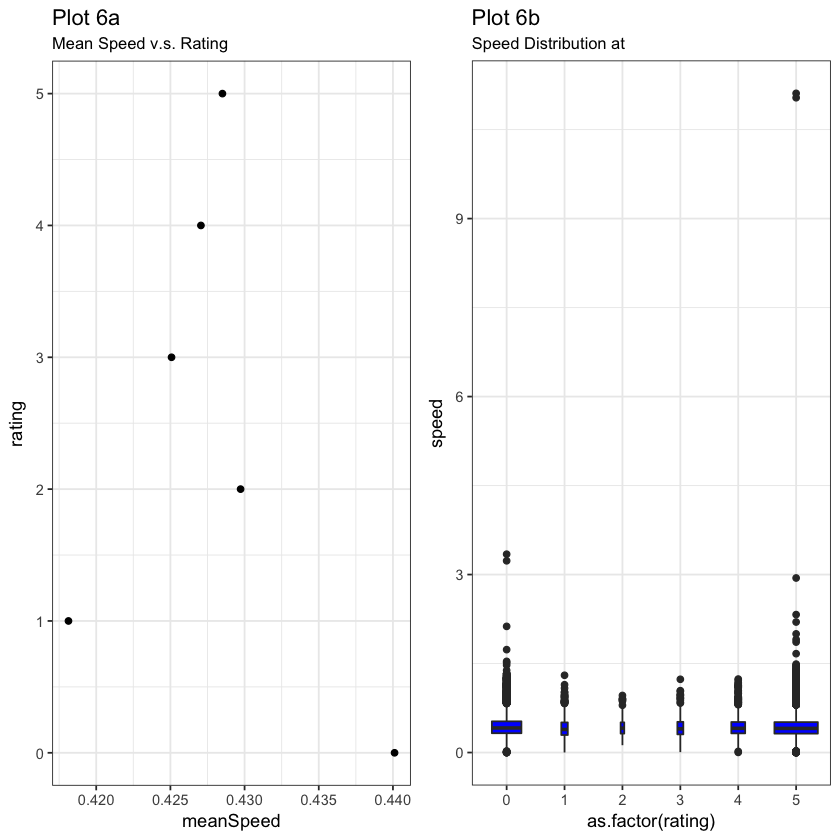

In [81]:
gScatterPlot = ggplot(hyp2DataAvg, aes(x = meanSpeed, y = rating)) + 
    geom_point() + 
    labs(subtitle="Mean Speed v.s. Rating",title = 'Plot 6a')
gBoxPlot = ggplot(hyp2Data, aes(as.factor(rating), speed)) + 
    geom_boxplot(varwidth=T, fill="blue") + 
    labs(subtitle="Speed Distribution at ",title = 'Plot 6b')
grid.arrange(gScatterPlot, gBoxPlot, ncol = 2)

From the above plots we do not see a significant effect of speed on ratings, we further confirm this by regressing ratings on meanSpeed

In [82]:
model = lm(rating~meanSpeed, data = hyp2DataAvg)
summary(model)


Call:
lm(formula = rating ~ meanSpeed, data = hyp2DataAvg)

Residuals:
      1       2       3       4       5       6 
-1.6608 -2.1970 -0.3861  0.2885  1.4270  2.5283 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)    32.42      53.86   0.602    0.580
meanSpeed     -69.89     125.79  -0.556    0.608

Residual standard error: 2.015 on 4 degrees of freedom
Multiple R-squared:  0.07165,	Adjusted R-squared:  -0.1604 
F-statistic: 0.3087 on 1 and 4 DF,  p-value: 0.6081


The p-values in the above t & F test confirm, that __Speeds do not have an effect on ratings__

# Hyp 3(Self) : Repeat trip instances of same driver & customer could result in higher ratings on an average

Repeat pairing of a drive & customer, generally results in an emotional connect between both the parties. This connect probably drives higher ratings & as a result rating for repeat instances could have a higher average. 
In case this is true while scheduling trips drivers who have driven with same customer in the past should be weighted higher for a match. How can we check for this?

I carry out the following steps:

-  For each group of customer & driver count number of trips and calculate average ratings over these trips
-  Next group over unique counts from step 1, compute average of average ratings from step 1 & number of instances of these counts within each group of count

In [113]:
hyp3DataTrain = dataTrain %>% group_by(customer_id,driver_id) %>% filter(rating > 0) %>%
    summarise(count = n(),avgRating = mean(rating)) %>% arrange(desc(count)) %>% ungroup() %>% 
    group_by(count) %>% summarize(rating = mean(avgRating),instances= n())
paste('Train Data Summary')
hyp3DataTrain

hyp3DataTrip = dataTripRating %>% group_by(customer_id,driver_id) %>% filter(rating > 0) %>%
    summarise(count = n(),avgRating = mean(rating)) %>% arrange(desc(count)) %>% ungroup() %>% 
    group_by(count) %>% summarize(rating = mean(avgRating),instances= n())
paste('Trip Rating Data Summary')
hyp3DataTrip

[1] "Train Data Summary"

count,rating,instances
1,4.776704,33637
2,4.833984,512
3,4.891473,43
4,5.000000,12
5,5.000000,3
6,5.000000,1
9,5.000000,2


[1] "Trip Rating Data Summary"

count,rating,instances
1,4.784533,32223
2,4.815895,497
3,4.880342,39
4,4.958333,6
5,5.000000,2
7,5.000000,2
9,5.000000,1
14,5.000000,1


Next we plot num of repeat instances i.e. count v.s. rating from each summary table above

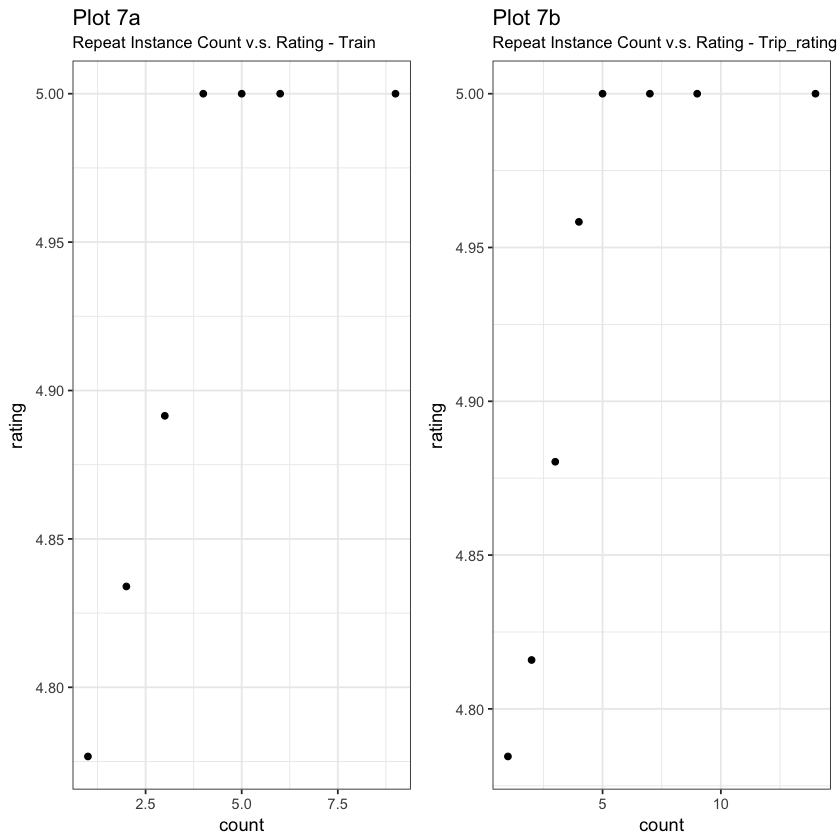

In [114]:
gScatterPlotTrain = ggplot(hyp3DataTrain, aes(x = count, y = rating)) + 
    geom_point() + 
    labs(subtitle="Repeat Instance Count v.s. Rating - Train",title = 'Plot 7a')

gScatterPlotTrip = ggplot(hyp3DataTrip, aes(x = count, y = rating)) + 
    geom_point() + 
    labs(subtitle="Repeat Instance Count v.s. Rating - Trip_rating",title = 'Plot 7b')

grid.arrange(gScatterPlotTrain,gScatterPlotTrip,ncol =2)

A log releationship is evident from the above plots, we confirm this further using a linear model

In [116]:
model1 = lm(rating~log(count), data = hyp3DataTrain)
summary(model1)
model2 = lm(rating~log(count), data = hyp3DataTrip)
summary(model2)


Call:
lm(formula = rating ~ log(count), data = hyp3DataTrain)

Residuals:
        1         2         3         4         5         6         7 
-0.001021 -0.027306 -0.018700  0.055144  0.028242  0.006262 -0.042621 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.77772    0.02923 163.472 1.63e-10 ***
log(count)   0.12056    0.02049   5.883  0.00202 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03685 on 5 degrees of freedom
Multiple R-squared:  0.8738,	Adjusted R-squared:  0.8485 
F-statistic: 34.61 on 1 and 5 DF,  p-value: 0.002016



Call:
lm(formula = rating ~ log(count), data = hyp3DataTrip)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.04674 -0.02168 -0.00357  0.02445  0.05412 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.78821    0.02784 171.968 2.61e-12 ***
log(count)   0.09796    0.01688   5.805  0.00115 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03791 on 6 degrees of freedom
Multiple R-squared:  0.8489,	Adjusted R-squared:  0.8237 
F-statistic:  33.7 on 1 and 6 DF,  p-value: 0.001146


P-values for both the t-test & F-test confirm our intution that repeat instances could result in higher ratings. A final note here the findings here are based on correlation & shouldnot be interpretted for causation, i.e. it is not neccesary that repeat pairing of  customer & driver would always result in a higher rating, it is overall average that  improves.

# Predicting Rating Probability

Based on our inferences from the above sections we add only one additional feature, historical rating probability for each customer_id from the trip_rating data set. For cases this value is unknown we assume that this for a customer corresponds to 0.5. Also as speeds do not contribute to improvements in ratings they are less likely to contribute to probability of rating too. No cleaning rules are implemented on the the train set as anomalies observed in the training set are also present in the test case. The prediction model is only developed for the case when the trip is not cancelled & in case this is cancelled was_rated is 0 in both train & test data sets.

As next steps we first transform the trip_rating data set to compute the rating probability at a customer level & merge this information with the train data set

In [184]:
dataTripRatingTransform = dataTripRating %>% mutate(was_rated = ifelse(rating == 0, 0,1))
dataTripRatingTransform = dataTripRatingTransform %>% select(-X1,-driver_id) %>% 
    group_by(customer_id) %>% summarise(mean_rating_prob = mean(was_rated),sd_rating_prob = sd(was_rated)) %>% 
    ungroup()

dataTripRatingTransform = dataTripRatingTransform %>% 
    mutate(sd_rating_prob = ifelse(is.na(sd_rating_prob),0,sd_rating_prob))

dataModel = left_join(dataTrain, dataTripRatingTransform, by = 'customer_id')

p = 0.5
p_sd = 0
dataModel = dataModel %>% mutate(mean_rating_prob = ifelse(is.na(mean_rating_prob),p, mean_rating_prob))
dataModel = dataModel %>% mutate(sd_rating_prob = ifelse(is.na(sd_rating_prob),p_sd, sd_rating_prob))


In [185]:
dataTripRatingTransform = dataTripRating %>% mutate(was_rated = ifelse(rating == 0, 0,1))

dataTripRatingTransform = dataTripRatingTransform %>% select(-X1,-customer_id) %>% 
    group_by(driver_id) %>% 
    summarise(drGet_rating_prob_mean = mean(was_rated),drGet_rating_prob_sd = sd(was_rated)) %>% ungroup()

dataModel = left_join(dataModel, dataTripRatingTransform, by = 'driver_id')

dataTripRatingTransform = dataTripRatingTransform %>% 
    mutate(drGet_rating_prob_sd = ifelse(is.na(drGet_rating_prob_sd),0,drGet_rating_prob_sd))

p = 0.5
p_sd = 0
dataModel = dataModel %>% 
    mutate(drGet_rating_prob_mean = ifelse(is.na(drGet_rating_prob_mean),p, drGet_rating_prob_mean))
dataModel = dataModel %>% 
    mutate(drGet_rating_prob_sd = ifelse(is.na(drGet_rating_prob_sd),p_sd, drGet_rating_prob_sd))

In [186]:
dataModel = dataModel %>% mutate(hourSlot = hour(creation_date))

In [187]:
dataModel = dataModel %>% filter(is_cancelled == 0) %>%
    select(-X1,-customer_id,-driver_id, -creation_date,-rating,is_cancelled,-rating)

factorVars = c('booking_source', 'car_type','hourSlot','was_rated')
dataModel = dataModel %>% mutate_at(factorVars,funs(as.factor(.)))

In [188]:
glimpse(dataModel)

Observations: 48,898
Variables: 18
$ booking_source                  <fct> 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1,...
$ car_type                        <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ estimated_distance              <dbl> 0.000, 0.000, 0.000, 0.000, 0.000, ...
$ distance_travelled              <dbl> 7.286660, 1.258360, 14.578200, 1.51...
$ distance_travelled_while_moving <dbl> 7.177120, 1.056640, 14.440600, 1.18...
$ estimated_duration              <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ duration_time                   <int> 11, 4, 16, 8, 19, 16, 10, 19, 28, 5...
$ wait_time_initial               <int> 18, 1, 3, 0, 1, 2, 3, 2, 9, 3, 3, 4...
$ wait_time_in_journey            <int> 2, 1, 2, 5, 4, 7, 3, 11, 11, 1, 7, ...
$ estimated_price                 <dbl> 0.000, 0.000, 0.000, 0.000, 0.000, ...
$ price                           <dbl> 17.375184, 8.507064, 19.745205, 10....
$ is_cancelled                    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ was_rated      

In [190]:
index = createDataPartition(dataModel$was_rated, p =0.8, list = FALSE)
dataModelTrain = dataModel[index,]
dataModelVer = dataModel[-index,]

In [196]:
ctrl = trainControl(method = 'repeatedcv', number = 3, repeats = 3, verboseIter = FALSE, search = 'random')
modelRF = suppressWarnings(caret::train(was_rated~., data = dataModelTrain, method = 'rf', preProcess = c('scale','center'),trControl = ctrl, importance = TRUE))

ERROR: Error: package e1071 is required


In [1]:
install.packages('caret', dependencies = TRUE)

also installing the dependencies ‘bitops’, ‘spData’, ‘gdata’, ‘caTools’, ‘TH.data’, ‘profileModel’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘plotrix’, ‘classInt’, ‘labelled’, ‘gplots’, ‘multcomp’, ‘brglm’, ‘gtools’, ‘lme4’, ‘qvcalc’, ‘plotmo’, ‘TeachingDemos’, ‘combinat’, ‘questionr’, ‘ROCR’, ‘mvtnorm’, ‘modeltools’, ‘strucchange’, ‘coin’, ‘ISwR’, ‘corpcor’, ‘BradleyTerry2’, ‘e1071’, ‘earth’, ‘fastICA’, ‘gam’, ‘klaR’, ‘ellipse’, ‘mda’, ‘mlbench’, ‘MLmetrics’, ‘party’, ‘pls’, ‘pROC’, ‘proxy’, ‘RANN’, ‘spls’, ‘subselect’, ‘pamr’, ‘superpc’, ‘Cubist’

Warning message in install.packages("caret", dependencies = TRUE):
“installation of package ‘bitops’ had non-zero exit status”Warning message in install.packages("caret", dependencies = TRUE):
“installation of package ‘minqa’ had non-zero exit status”Warning message in install.packages("caret", dependencies = TRUE):
“installation of package ‘nloptr’ had non-zero exit status”Warning message in install.packages("caret", dependencies = TRUE):
“installa

In [3]:
library(e1071)

ERROR: Error in library(e1071): there is no package called ‘e1071’
